In [1]:
import torch 
from torch import nn 
from torchvision import transforms
from torchvision.datasets import Omniglot
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.model_selection import ParameterSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

In [ ]:
augmentation1 = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  
    transforms.RandomRotation(15),                      
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


augmentation2 = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
class BYOLDataset(Dataset):
    def __init__(self, base_dataset, transform1, transform2):
        self.base_dataset = base_dataset
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx] 
        x1 = self.transform1(img)
        x2 = self.transform2(img)
        return x1, x2

In [ ]:
base_dataset = Omniglot(
    root='./data',
    background=True,
    download=True,
    transform=None  
)

byol_dataset = BYOLDataset(base_dataset, augmentation1, augmentation2)
dataloader = torch.utils.data.DataLoader(byol_dataset, batch_size=1024, shuffle=True)

Files already downloaded and verified


In [5]:
data_iter = iter(dataloader)
x1, x2 = next(data_iter)
print(x1.shape) 
print(x2.shape) 


torch.Size([1024, 1, 28, 28])
torch.Size([1024, 1, 28, 28])


In [ ]:
data_iter = iter(dataloader)
images, labels = next(data_iter)
images.shape

torch.Size([1024, 1, 28, 28])

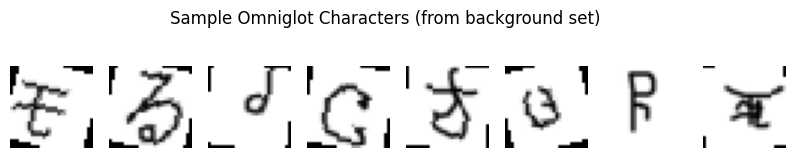

In [7]:
plt.figure(figsize=(10, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(images[i].squeeze(0).numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle("Sample Omniglot Characters (from background set)")
plt.show()

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim=64, out_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, padding=1),  # 28x28
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 14x14

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 7x7

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 3x3

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # -> 1x1
        )
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.encoder(x)          
        x = x.view(x.size(0), -1)    # Flatten to (B, hidden_dim)
        return self.fc(x)           

In [9]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=256, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [10]:
class OnlineNetwork(nn.Module):
    def __init__(self, encoder, feature_dim=64, proj_hidden_dim=256, proj_out_dim=256):
        super().__init__()
        self.encoder = encoder
        self.projector = MLP(feature_dim, proj_hidden_dim, proj_out_dim)
        self.predictor = MLP(proj_out_dim, proj_hidden_dim // 2, proj_out_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        predictions = self.predictor(projections)
        return predictions, projections

In [11]:
class TargetNetwork(nn.Module):
    def __init__(self, encoder, feature_dim=64, proj_hidden_dim=256, proj_out_dim=256):
        super().__init__()
        self.encoder = encoder
        self.projector = MLP(feature_dim, proj_hidden_dim, proj_out_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return projections


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
encoder = Encoder(hidden_dim=64, out_dim=64)

online_net = OnlineNetwork(encoder, feature_dim=64, proj_hidden_dim=256, proj_out_dim=256)
target_net = TargetNetwork(encoder, feature_dim=64, proj_hidden_dim=256, proj_out_dim=256)
online_net.to(device)
target_net.to(device)

TargetNetwork(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(64, eps=1e-05, mo

In [14]:
def loss_fn(p, z):
    p = F.normalize(p, dim=-1)
    z = F.normalize(z.detach(), dim=-1)
    return 2 - 2 * (p * z).sum(dim=-1).mean()

In [15]:
@torch.no_grad()
def update_target_network(online_net, target_net, beta=0.996):
    for param_o, param_t in zip(online_net.parameters(), target_net.parameters()):
        param_t.data = beta * param_t.data + (1 - beta) * param_o.data

In [ ]:
param_grid = {
    'lr': [3e-4, 1e-4, 3e-5],
    'weight_decay': [1e-4, 1e-6, 0],
    'scheduler_type': ['cosine', 'plateau'],
}

num_search_iter = 5  
best_loss = float('inf')
best_params = None


initial_online_state = {k: v.clone() for k, v in online_net.state_dict().items()}
initial_target_state = {k: v.clone() for k, v in target_net.state_dict().items()}

for params in ParameterSampler(param_grid, n_iter=num_search_iter):
    print(f"\nTraining with params: {params}")

    
    online_net.load_state_dict(initial_online_state)
    target_net.load_state_dict(initial_target_state)

    
    lr = params['lr']
    weight_decay = params['weight_decay']
    epochs = 100
    scheduler_type = params['scheduler_type']

    optimizer = torch.optim.Adam(online_net.parameters(), lr=lr, weight_decay=weight_decay)

    if scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    elif scheduler_type == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
    else:
        scheduler = None

    online_net = online_net.to(device)
    target_net = target_net.to(device)
    target_net.eval()

    total_loss_epoch = 0  

    for epoch in range(epochs):
        online_net.train()
        total_loss = 0
        loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")

        for x1, x2 in loop:
            x1, x2 = x1.to(device), x2.to(device)

            optimizer.zero_grad()

           
            p1, z1 = online_net(x1)

           
            with torch.no_grad():
                z2 = target_net(x2)

            loss1 = loss_fn(p1, z2)

         
            p2, z2_online = online_net(x2)

            with torch.no_grad():
                z1_target = target_net(x1)

            loss2 = loss_fn(p2, z1_target)

            loss = (loss1 + loss2) / 2
            loss.backward()
            optimizer.step()

            
            update_target_network(online_net, target_net, beta=0.996)

            total_loss += loss.item()
            avg_loss = total_loss / (loop.n + 1)
            loop.set_postfix(loss=avg_loss)

       
        total_loss_epoch = total_loss / len(dataloader)

        
        if scheduler_type == 'cosine':
            scheduler.step()
        elif scheduler_type == 'plateau':
            scheduler.step(total_loss_epoch)

    
    print(f"Final Avg Loss: {total_loss_epoch:.4f}")

    if total_loss_epoch < best_loss:
        best_loss = total_loss_epoch
        best_params = params
        target_encoder = target_net.encoder
        torch.save(target_encoder.state_dict(), 'best_model.pth')

print("\nBest Params:", best_params)
print("Best Validation Loss:", best_loss)

c:\Users\ACER\.conda\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training with params: {'weight_decay': 1e-06, 'scheduler_type': 'plateau', 'lr': 3e-05}


Epoch [100/100]: 100%|██████████| 19/19 [00:23<00:00,  1.22s/it, loss=0.0225]


Final Avg Loss: 0.0225

Training with params: {'weight_decay': 0.0001, 'scheduler_type': 'cosine', 'lr': 0.0001}


Epoch [100/100]: 100%|██████████| 19/19 [00:24<00:00,  1.27s/it, loss=0.0212]


Final Avg Loss: 0.0212

Training with params: {'weight_decay': 1e-06, 'scheduler_type': 'cosine', 'lr': 0.0003}


Epoch [100/100]: 100%|██████████| 19/19 [00:23<00:00,  1.26s/it, loss=0.0275]


Final Avg Loss: 0.0275

Training with params: {'weight_decay': 1e-06, 'scheduler_type': 'cosine', 'lr': 0.0001}


Epoch [100/100]: 100%|██████████| 19/19 [00:23<00:00,  1.24s/it, loss=0.0485]


Final Avg Loss: 0.0485

Training with params: {'weight_decay': 0.0001, 'scheduler_type': 'cosine', 'lr': 3e-05}


Epoch [100/100]: 100%|██████████| 19/19 [00:23<00:00,  1.23s/it, loss=0.0487]

Final Avg Loss: 0.0487

Best Params: {'weight_decay': 0.0001, 'scheduler_type': 'cosine', 'lr': 0.0001}
Best Validation Loss: 0.021158262303001003
